### Some Analysis of the NOAA weather dataset ###

In this notebook we are analyzing a sample out of data that was downloaded from http://www1.ncdc.noaa.gov/pub/data/ghcn/daily/, the main file is ghcnd_all.tar.gz which is about 2.4 GB which becomes around 20GB when uncompressed.

The data contains about 1 million station-year recordings. That is too much to analyzer on single core machine, so we start by taking a sample of 20,000 recordings of the maximal daily temperatures for a period of a 365 days starting on January 1st (the last day of leap years is discarded).

### Checking the versions of some important packages ###

In [ ]:
!pip install --upgrade matplotlib

In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
%pylab inline
print('pandas version: ',pd.__version__)
print('numpy version:',np.__version__)
print('sklearn version:',sk.__version__)
print('matplotlib version:', matplotlib.__version__)

Switch to the data directory and check it's contents

In [ ]:
%cd ../data/weather
#%cd ~/BigData/UCSD_BigData_2016/data/weather/    
#%cs ~/data/weather
!ls -lh

In [ ]:
!cat data-source.txt

- *data-source.txt* - information about downloading the data from NOAA
- *ghcnd-readme.txt* - A readme file describing the content of all of the files from ghcnd, in particular:
- *ghcnd-stations.txt* - information about each of the meteorological stations.
- *Sample_TMAX* - a file with 10,000 randomly selected one-year-long TMAX measurements

In [ ]:
#!head -1 SAMPLE_TMAX.csv
# a Typical single line in the data file
file=open('SAMPLE_TMAX.csv','r')
for line in file.readlines():
    print(line)
    print(len(line.split(',')))
    break

### read data into a Pandas Dataframe ##
* Read the data into a DataFrame
* Read the data vectors in G
* Divide by 10.0 to get the temperatude in degrees celsius
* Replace values outside the range [-400,500]  ([-40,50] degrees celsius) with nan  
* Paste fixed matrix back into Dout
* Show the first few lines of DDout

In [ ]:
#using 2001 which was not a leap year (2000 was)
days_index=pd.date_range('January 1, 2001', periods=365,freq='D')
days=list(days_index)

In [ ]:
# header=['station','measurement','year']+dates_in_year
columns=['station','measurement','year']+days
# D=pandas.DataFrame(columns=header)
Data = pd.read_csv('SAMPLE_TMAX.csv',header=None,names=columns)
Data.head()

### Selecting rows and columns in a dataframe

* To select a set of columns from a dataframe:
```
DF[['column2','column6','column1']]
```
This returns a new dataframe containing the selected columns in the selected order.

* To select a set of rows based on a condition defined using one of the coluns:
```
DF[DF['column1']>5]
```

More sophisticated selections can be down using:
* `.loc` : select according to the name of the column or row.
* `.iloc` : select according to the position of the column or row.
* `.ix` : a hybrid of `.loc` and `.iloc` that allows mixing names and positions.

Resources:
* [A tutorial on selecting rows and columns in a dataframe using iloc, loc and ix](http://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/)
* [Pandas Cheat Sheet](https://mas-dse.github.io/DSE200/cheat_sheets/1_python/7_1_Pandas_DataFrame_Notes.pdf)

In [10]:
# some data cleaning
G=Data.loc[:,days]
G[G<-400]=np.nan
G[G>500]=np.nan
G=G/10
Data.loc[:,days]=G
G=G.transpose()

(7300000,) <class 'pandas.core.series.Series'>
-40.0 50.0


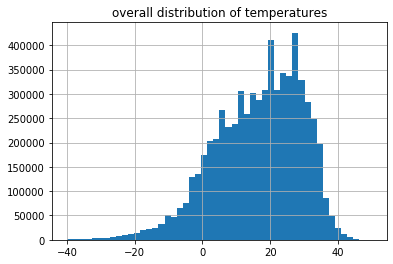

In [17]:
# compute the histogram
tmp=G.loc[:,:].unstack()
#print(tmp.head())
print(shape(tmp), type(tmp))
tmp.hist(bins=50);
title('overall distribution of temperatures')
print(tmp.min(),tmp.max())

### Script for plotting yearly plots ###

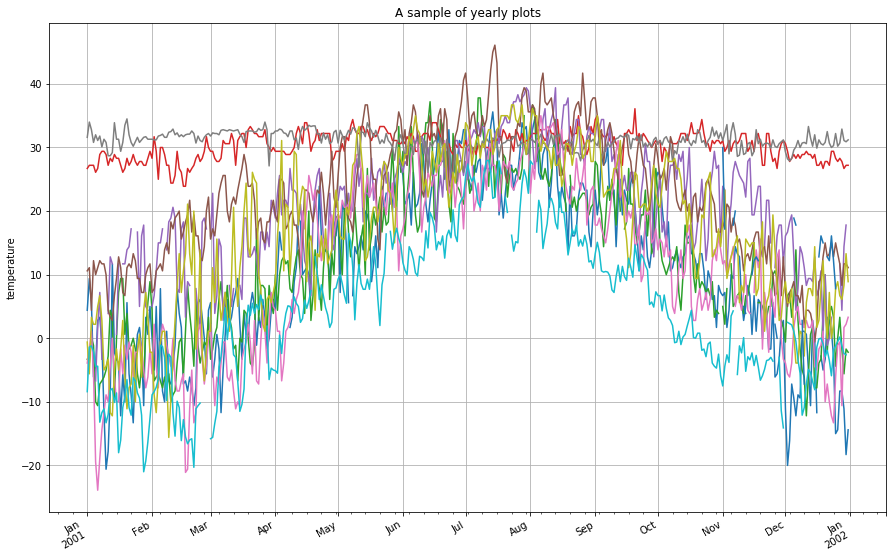

In [19]:
def YearlyPlots(T,ttl='',size=(15,10)):
    #fig, ax = plt.subplots(1)
    #print shape(T), shape(days), type(T)
    if shape(T)[0] != 365:
        raise ValueError("First dimension of T should be 365. Shape(T)="+str(shape(T)))
    T.set_index(days_index)
    T.plot(legend=False,figsize=size)
    # rotate and align the tick labels so they look better
    gcf().autofmt_xdate()
    ylabel('temperature')
    grid()
    title(ttl)
YearlyPlots(Data.loc[20:30,days].transpose(),ttl='A sample of yearly plots')

### Plots for sydney, Australia ###

['ASN00066124' 'ASN00066059' 'ASN00066194' 'ASN00066131' 'ASN00066195'
 'ASN00066062']
(368, 6)


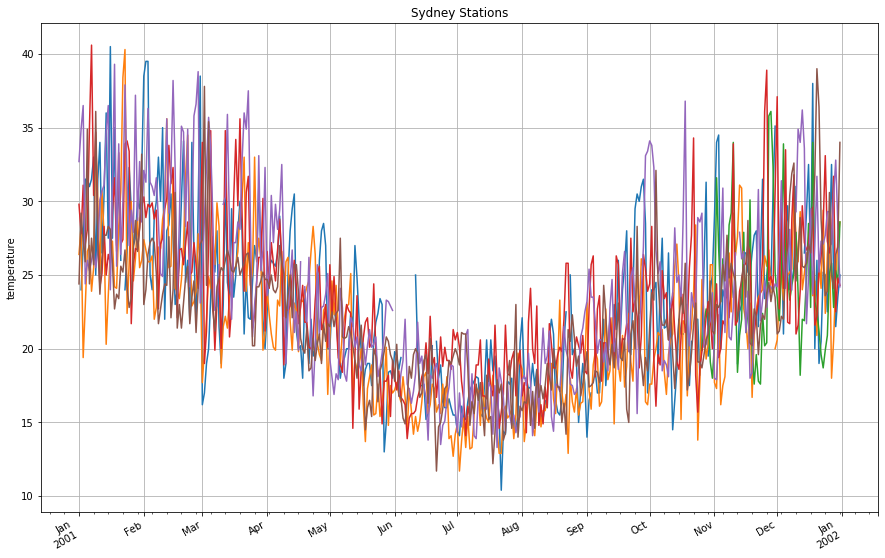

In [21]:
sydneyStations=['ASN00066' in station for station in Data['station']]
print(Data[sydneyStations]['station'].values)
tmp=Data[sydneyStations].transpose()
print(shape(tmp))
YearlyPlots(tmp.loc[days,:],ttl='Sydney Stations')

### Computing mean and std for each station/year ###
And calculating the standard deviation for each year.

In [ ]:
# a simple scale function to normalize the data-frame row-by-row
from numpy import mean, std
def Compute_mean_std(Din):
    matrix=Din.loc[:,days]
    Din['Mean']=mean(matrix, axis=1).values 
    Din['Std']=std(matrix, axis=1).values
    return Din

if 'measurement' in Data.columns:
    Data=Data.drop('measurement',axis=1)  # remove column that is the constant TMAX
Dout=Compute_mean_std(Data)
#reorder the columns
Dout=Dout[['station','year','Mean','Std']+days]
Dout.head()

### Compute average temperature for each day of the year. ###

(365, 1)

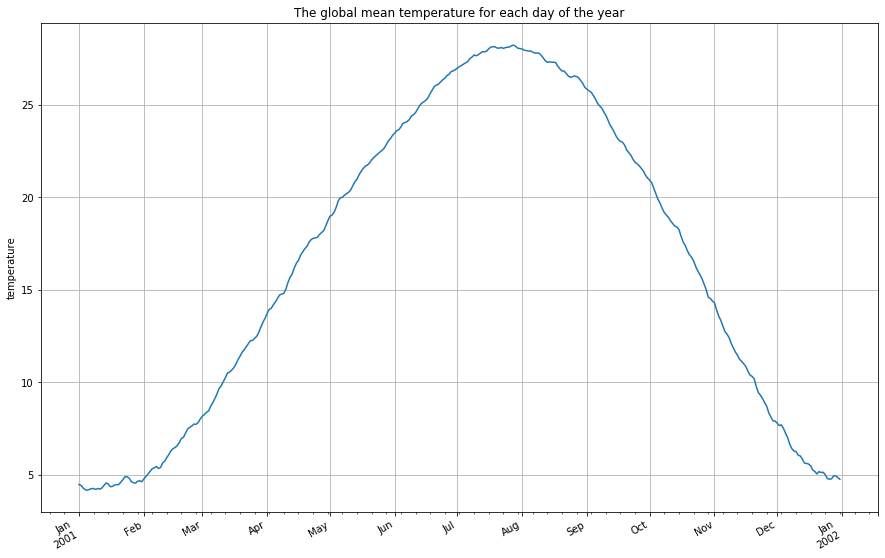

In [23]:
Mean=pd.DataFrame(mean(Dout.loc[:,days], axis=0))
#Mean=mean(Dout.ix[:,days], axis=0)
YearlyPlots(Mean,ttl='The global mean temperature for each day of the year')
shape(Mean)

In [24]:
pd.DataFrame.set_axis?

### SVD ###

### Missing Values ###
We find the distribution of missing values and decide how to deal with them. From the analysis below we see that most rows have some
missing values. We therefor choose to perform the average more carefully, rather than discard rows with many missing values

3760

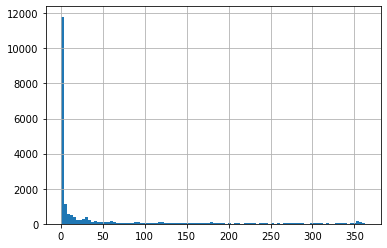

In [26]:
nan_per_row=sum(isnan(Dout.iloc[:,1:365]),axis=1)
nan_per_row.hist(bins=100)
sum(nan_per_row>50)

### NaN-tolerant averaging  ###
We compute the empirical covariance matrix in a way that tolerates NaN values.

<span style="color:red"> In the code below I remove all rows that have a nan in them. If you remve the command **M.dropna(...** then all rows are used. Can you get better results without removing the rows? </span>

In [ ]:
sum(nan_per_row>50)

In [ ]:
max_nan=50

M=Dout.loc[:,days].transpose()
#M.drop(nan_per_row>0,axis=1,inplace=True)
M=M.loc[:,nan_per_row<max_nan]
Dout=Dout.loc[nan_per_row<max_nan,:]
Dout.index=range(shape(Dout)[0])
(columns,rows)=shape(M)
Mean=mean(M, axis=1).values

print (columns,rows), shape(Mean),shape(M),shape(Dout)
C=np.zeros([columns,columns])   # Sum
N=np.zeros([columns,columns])   # Counter of non-nan entries
Dout.head()

In [ ]:
#%%time
for i in range(rows):
    if i % 1000==0: 
        print(i)
    row=M.iloc[:,i]-Mean;
    outer=np.outer(row,row)
    valid=isnan(outer)==False
    C[valid]=C[valid]+outer[valid]  # update C with the valid location in outer
    N[valid]=N[valid]+1
#valid_outer=np.multiply(1-isnan(N),N>0)
cov=np.divide(C,N)

In [ ]:
shape(cov)

In [ ]:
U,D,V=np.linalg.svd(cov)

In [ ]:
shape(U),shape(D),shape(V)

### Percentage of variance Explained ###

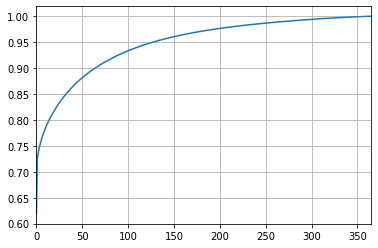

In [37]:
plot(cumsum(D[:])/sum(D))
xlim([0,365])
grid()

(365, 5)


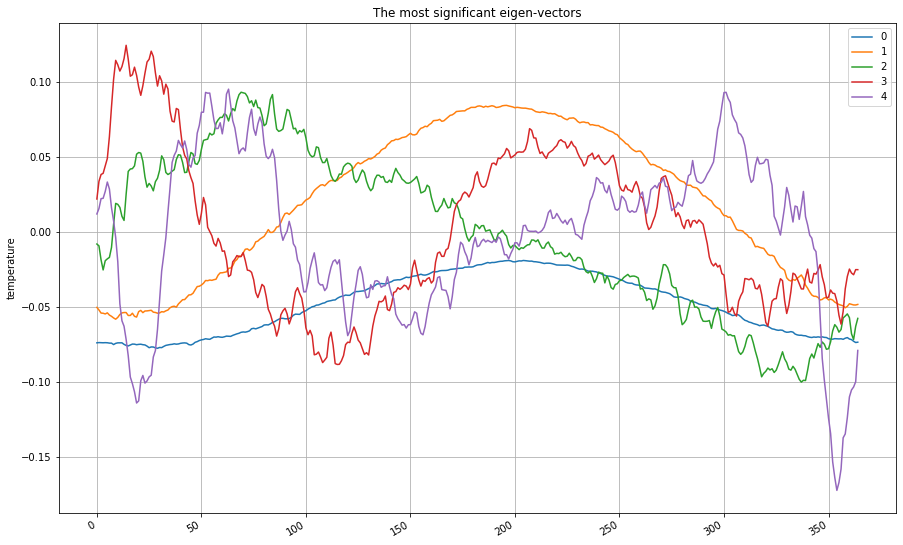

In [39]:
k=5 # number of components to show.
DF_U=pd.DataFrame(U[:,:k])
print(shape(DF_U))
YearlyPlots(DF_U,ttl='The most significant eigen-vectors')
legend(range(0,k));

In [ ]:
k=5
Eig=np.matrix(U[:,:k])
print('checking that the norm of the eigenvectors is always 1')
print(['%6.3f,'%np.linalg.norm(U[:,i]) for i in range(k)])
matrix=np.matrix(Dout.loc[:,days])-Mean.transpose()

#replacing nans with zeros
matrix[isnan(matrix)]=0
print(shape(Eig),shape(matrix))
Prod=matrix*Eig;
print(shape(Prod))

Insert coefficients for k top eigenvectors into the dataframe **Dout**

In [ ]:
for i in range(k-1,-1,-1):
    Ser=pd.Series(np.array(Prod)[:,i],index=Dout.index)
    Dout.insert(4,'V'+str(i),Ser)
Dout.head()

### Longitude,Latitude information ###
Loading the station longitude/latitude and merging it into the Table

In [ ]:
!ls

In [ ]:
!cat ghcnd-readme.txt   # uncomment to read the readme file.

In [ ]:
# Make all lines be of length 90 to solve problem wilth read_fwf
out=open('ghcnd-stations_buffered.txt','w')
for line in open('ghcnd-stations.txt','r').readlines():
    line=line.rstrip()
    string=line+' '*(90-len(line))+'\n'
    out.write(string)
out.close()

In [ ]:
colspecs = [(0, 11), (11, 21), (21, 31), (31, 38),(39,41),(41,72),(72,76),(76,80),(80,86)]
stations = pd.read_fwf('ghcnd-stations_buffered.txt', colspecs=colspecs, header=None, index_col=0,
                       names=['latitude','longitude','elevation','state','name','GSNFLAG','HCNFLAG','WMOID'])

In [ ]:
#stations['elevation'][stations['elevation']==-999.9]=0  # decided not to remove -999.9 because this confuses hist

In [ ]:
stations.head()

### perform a **JOIN** ###
Join the geographical information into **Dout**, creating a new dataframe called **Djoined**

In [ ]:
Djoined=Dout.join(stations,on='station')

In [ ]:
Djoined.columns

In [ ]:
Djoined['AbsLatitude']=abs(Djoined['latitude'].values)

In [ ]:
Djoined.loc[:5,['station',u'longitude','latitude',u'elevation',u'AbsLatitude','Mean','Std','V0','V1','V2']]

### Looking for significant correlations and dependencies ###

In [ ]:
Reduced=Djoined[['latitude','elevation','Mean','Std','V0','V1','V2','V3','V4']]
Reduced.cov()

<span style="color:red"> The correlations between different $V_i$ components should be zero, which it isn't.
Is this due to numerical roundoff errors? Are the correlations statistically significant for this sample size? </span>

In [ ]:
Reduced.corr()

In [ ]:
# Choosing significance threshold so that none of the correlations between the Vi-s are significant.
abs(Reduced.corr())>0.2

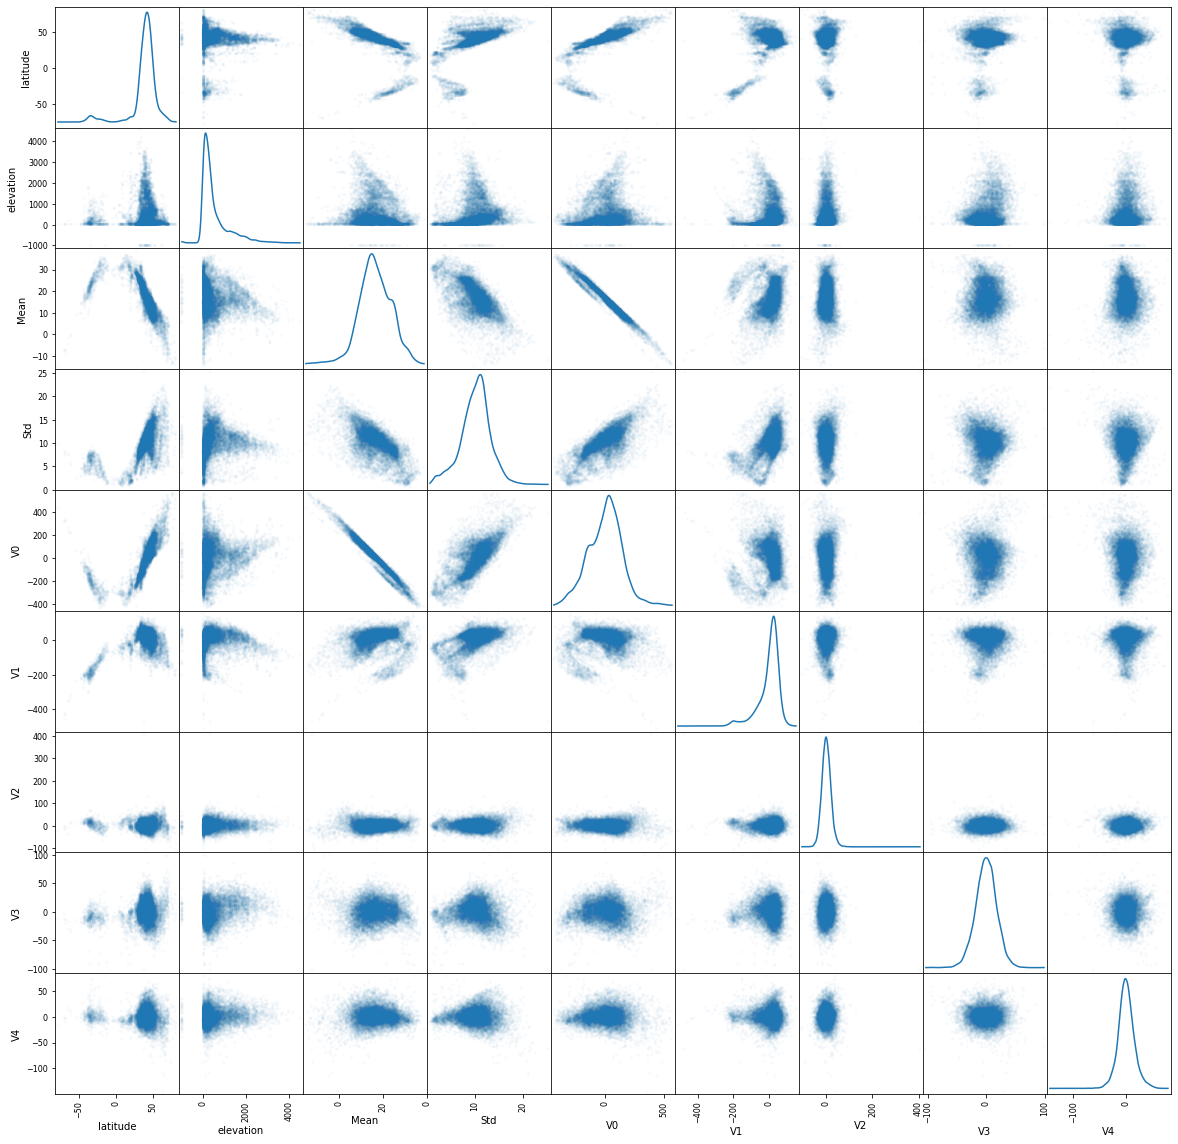

In [57]:
from pandas.plotting import scatter_matrix
scatter_matrix(Reduced, alpha=0.03, figsize=(20, 20), diagonal='kde');

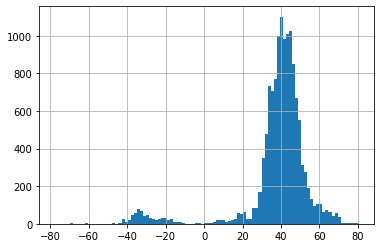

In [58]:
X='latitude'
Djoined.loc[:,X].hist(bins=100);

Text(0, 0.5, 'V0')

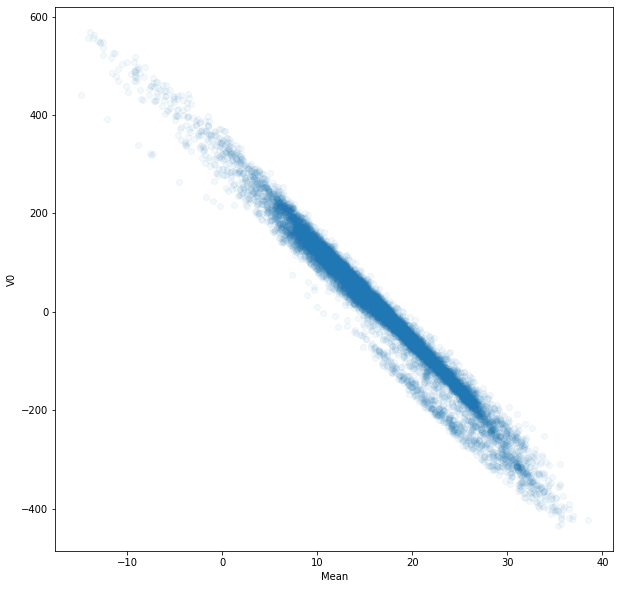

In [59]:
X='Mean';Y='V0'
figure(figsize=(10,10))
scatter(Djoined.loc[:,X],Djoined.loc[:,Y],alpha=0.05)
xlabel(X)
ylabel(Y)

In [ ]:
#checking for an anomaly in the elevations of stations
Djoined[['station','elevation']][Djoined['elevation']<-500].head()

In [ ]:
!grep ASN00010865 ghcnd-stations.txt

### Plotting maps ###
Working through http://matplotlib.org/basemap/

* http://en.wikipedia.org/wiki/Map_projection
* http://matplotlib.org/basemap/users/mapsetup.html

In [63]:
lons=stations.loc[:,'longitude'].values
lats=stations.loc[:,'latitude'].values
station_names=stations.index.values
ll=len(lons)
lonmin=-180;lonmax=180;latsmin=-80;latsmax=80;
select=(lons>lonmin) * (lons<lonmax)*(lats>latsmin)*(lats<latsmax)
print(sum(select))
station_names=station_names[select]
lons=lons[select]
lats=lats[select]
print(len(lons),len(lats),len(station_names))

85273
85273 85273 85273


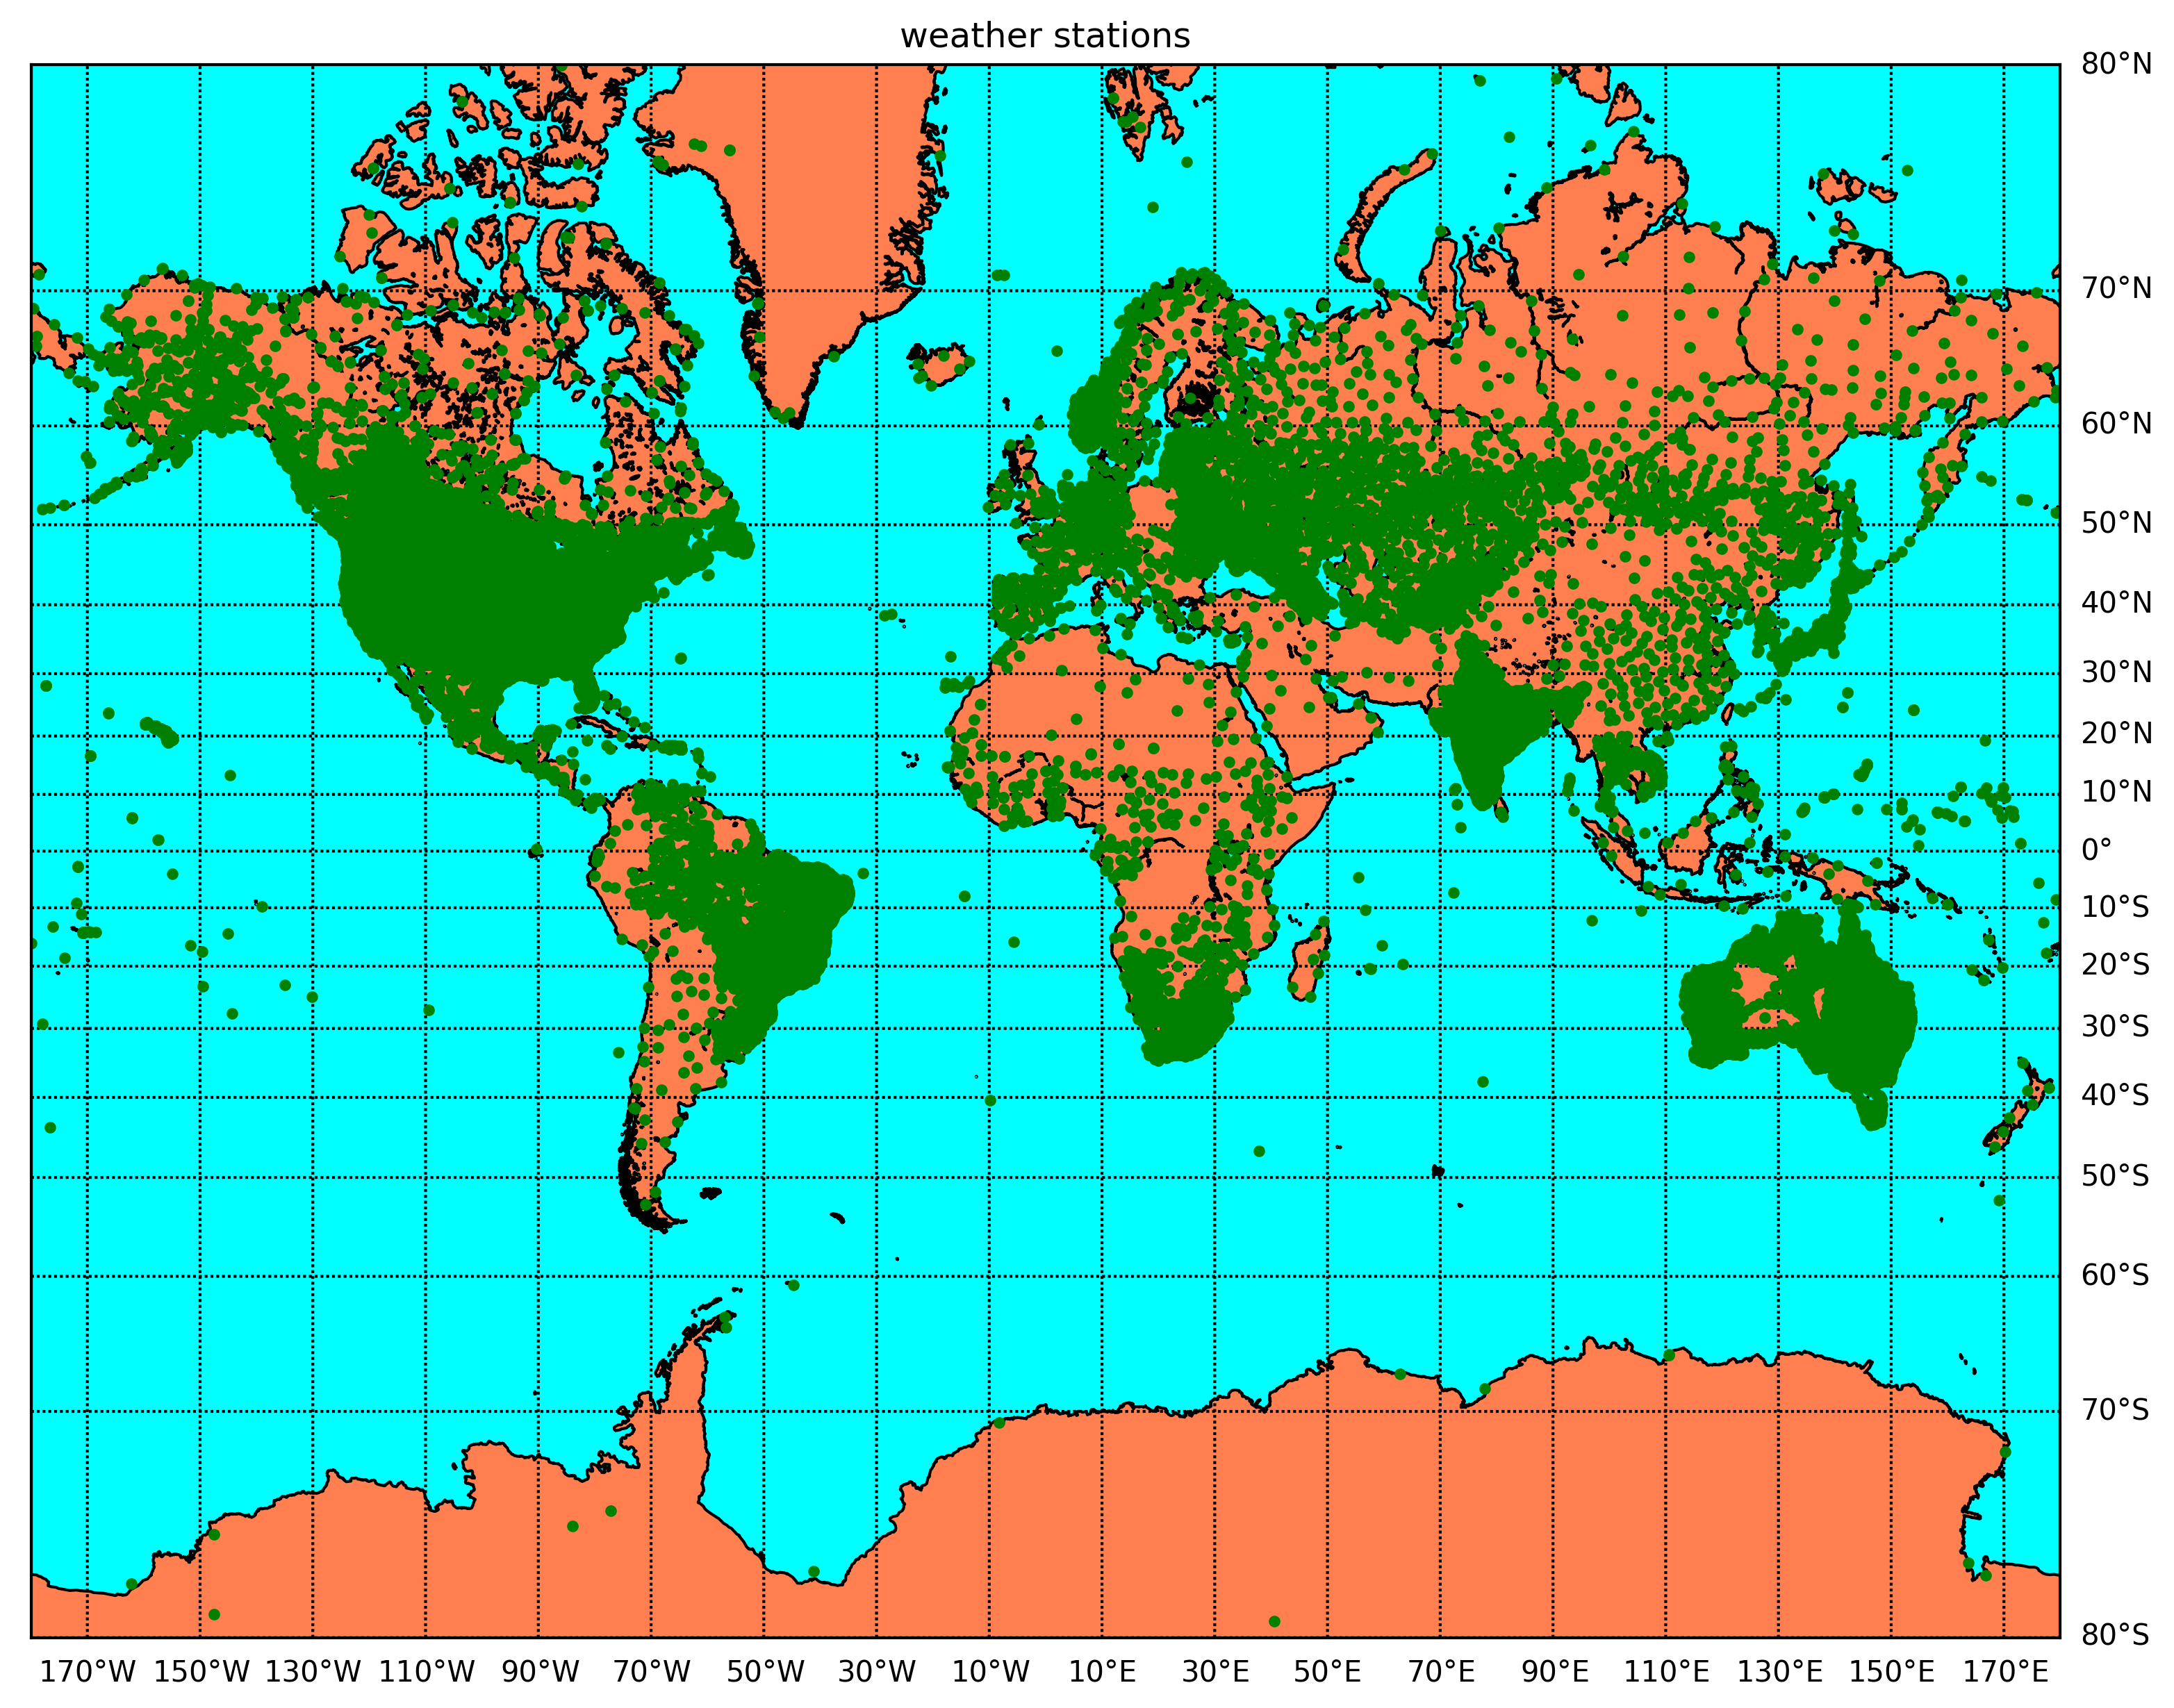

In [64]:
# http://matplotlib.org/basemap/users/merc.html

from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
# llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
# are the lat/lon values of the lower left and upper right corners
# of the map.
# lat_ts is the latitude of true scale.
# resolution = 'i' means use intermediate resolution coastlines.
plt.figure(figsize=(15,10),dpi=300)
m = Basemap(projection='merc',llcrnrlat=latsmin,urcrnrlat=latsmax,\
            llcrnrlon=lonmin,urcrnrlon=lonmax,lat_ts=20,resolution='i')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')

# draw parallels and meridians.
parallels = np.arange(-80,81,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(10.,351.,20.)
m.drawmeridians(meridians,labels=[True,False,False,True])

#m.drawparallels(np.arange(-90.,91.,30.))
#m.drawmeridians(np.arange(-180.,181.,60.))
m.drawmapboundary(fill_color='aqua')

# draw map with markers for locations
x, y = m(lons,lats)
m.plot(x,y,'g.')

plt.title('weather stations')
plt.show()


To get to these coordinate on Google Maps, type the latitude and longitude in decimal in the search box or use:
https://www.google.com/maps/place/72%C2%B018'00.0%22S+170%C2%B013'00.1%22E/@-72.3,170.216694,17z/data=!3m1!4b1!4m2!3m1!1s0x0:0x0

<span style="color:red">HW questions</span>

1. Waiting for somebody to write a script that will do that automatically from python
2. Can you create a map where the denity of points is represented as a density map (topographical map)?
3. Can you create a map that would represent, using color, the values of a chosen column (Mean, Std, V0,V1 etc.)? What conclusions can you draw from this map?


### Reconstruction ###

In [ ]:
KMean=np.array([Mean])

k=10
Keig=Eig[:,:k]
Kprod=Prod[:,:k]
Recon=pd.DataFrame(Kprod*Keig.transpose() +KMean)
Recon.columns=days_index

In [ ]:
print(shape(Djoined.loc[i,days]))
print(shape(Recon.loc[i,days]))

shape(Djoined),shape(Recon)

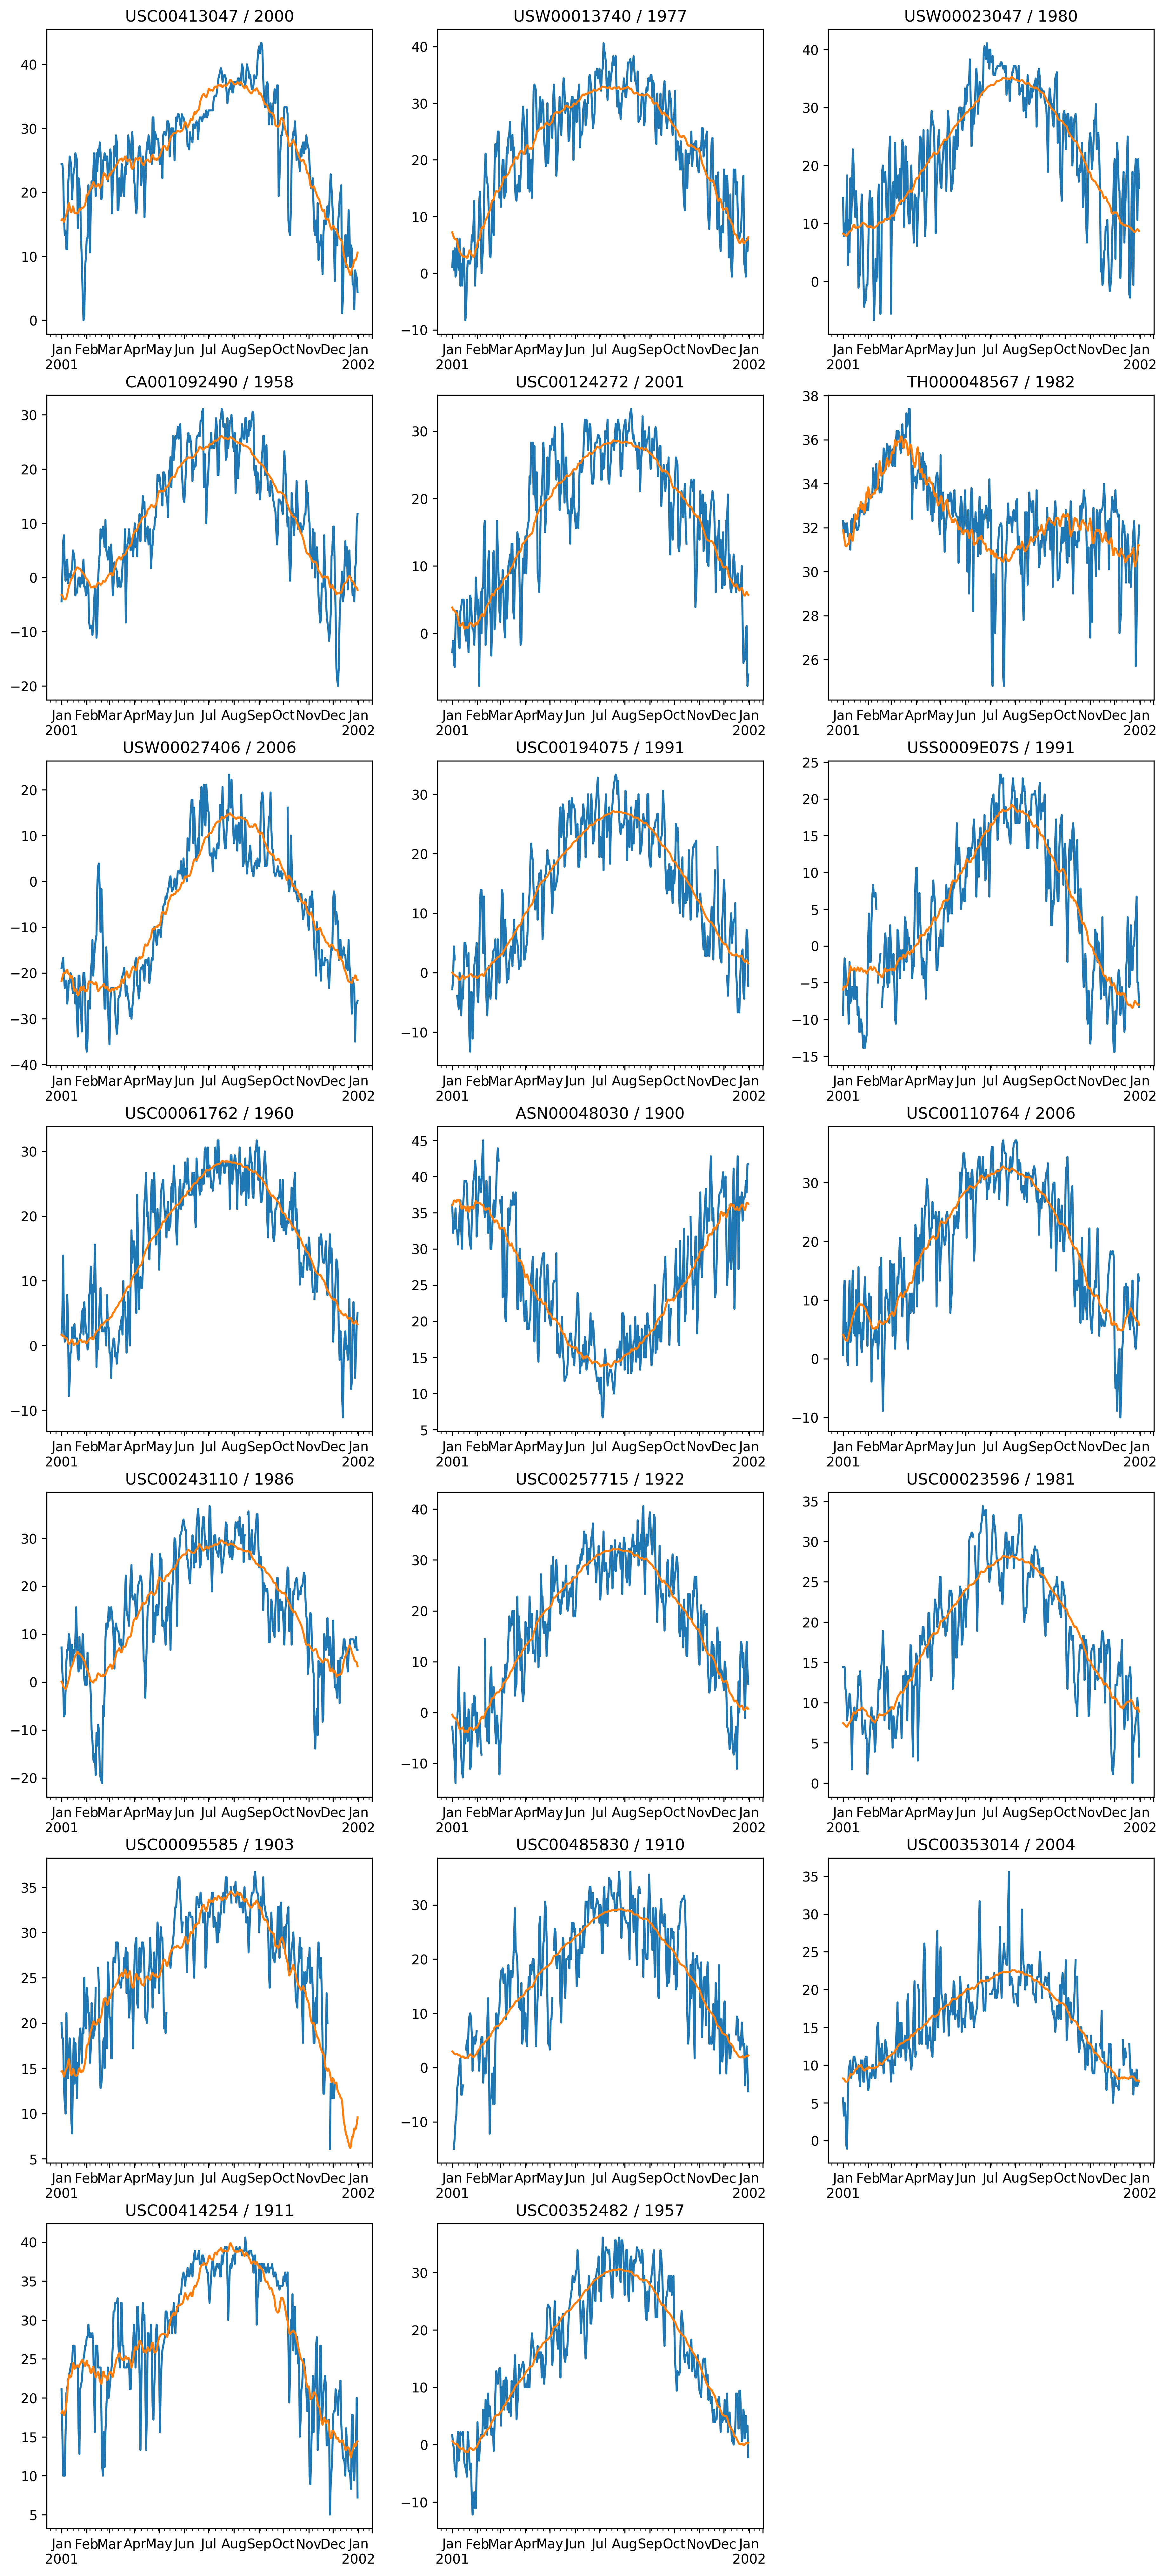

In [69]:
def plot_reconstructions(selection,rows=2,columns=7,size=3):
    plt.figure(figsize=(columns*size,rows*size),dpi=300)
    j=1;
    for i in selection:
        subplot(rows,columns,j); 
        j += 1; 
        if j>=rows*columns: 
            break
        (Djoined.loc[i,days]).plot()
        (Recon.loc[i,days]).plot()
        title(Djoined.loc[i,'station']+' / '+str(Djoined.loc[i,'year']))
plot_reconstructions(range(2000,2020),rows=10,columns=3,size=5)

Observe in the reconstructions below that the blue line fills in (extrapolation/interpolation) the places where the measurements are not available. It also reduces the fluctuations in the relative to the original line. Recall the we are using the k top eigenvectors which explain about 88% of the variance.

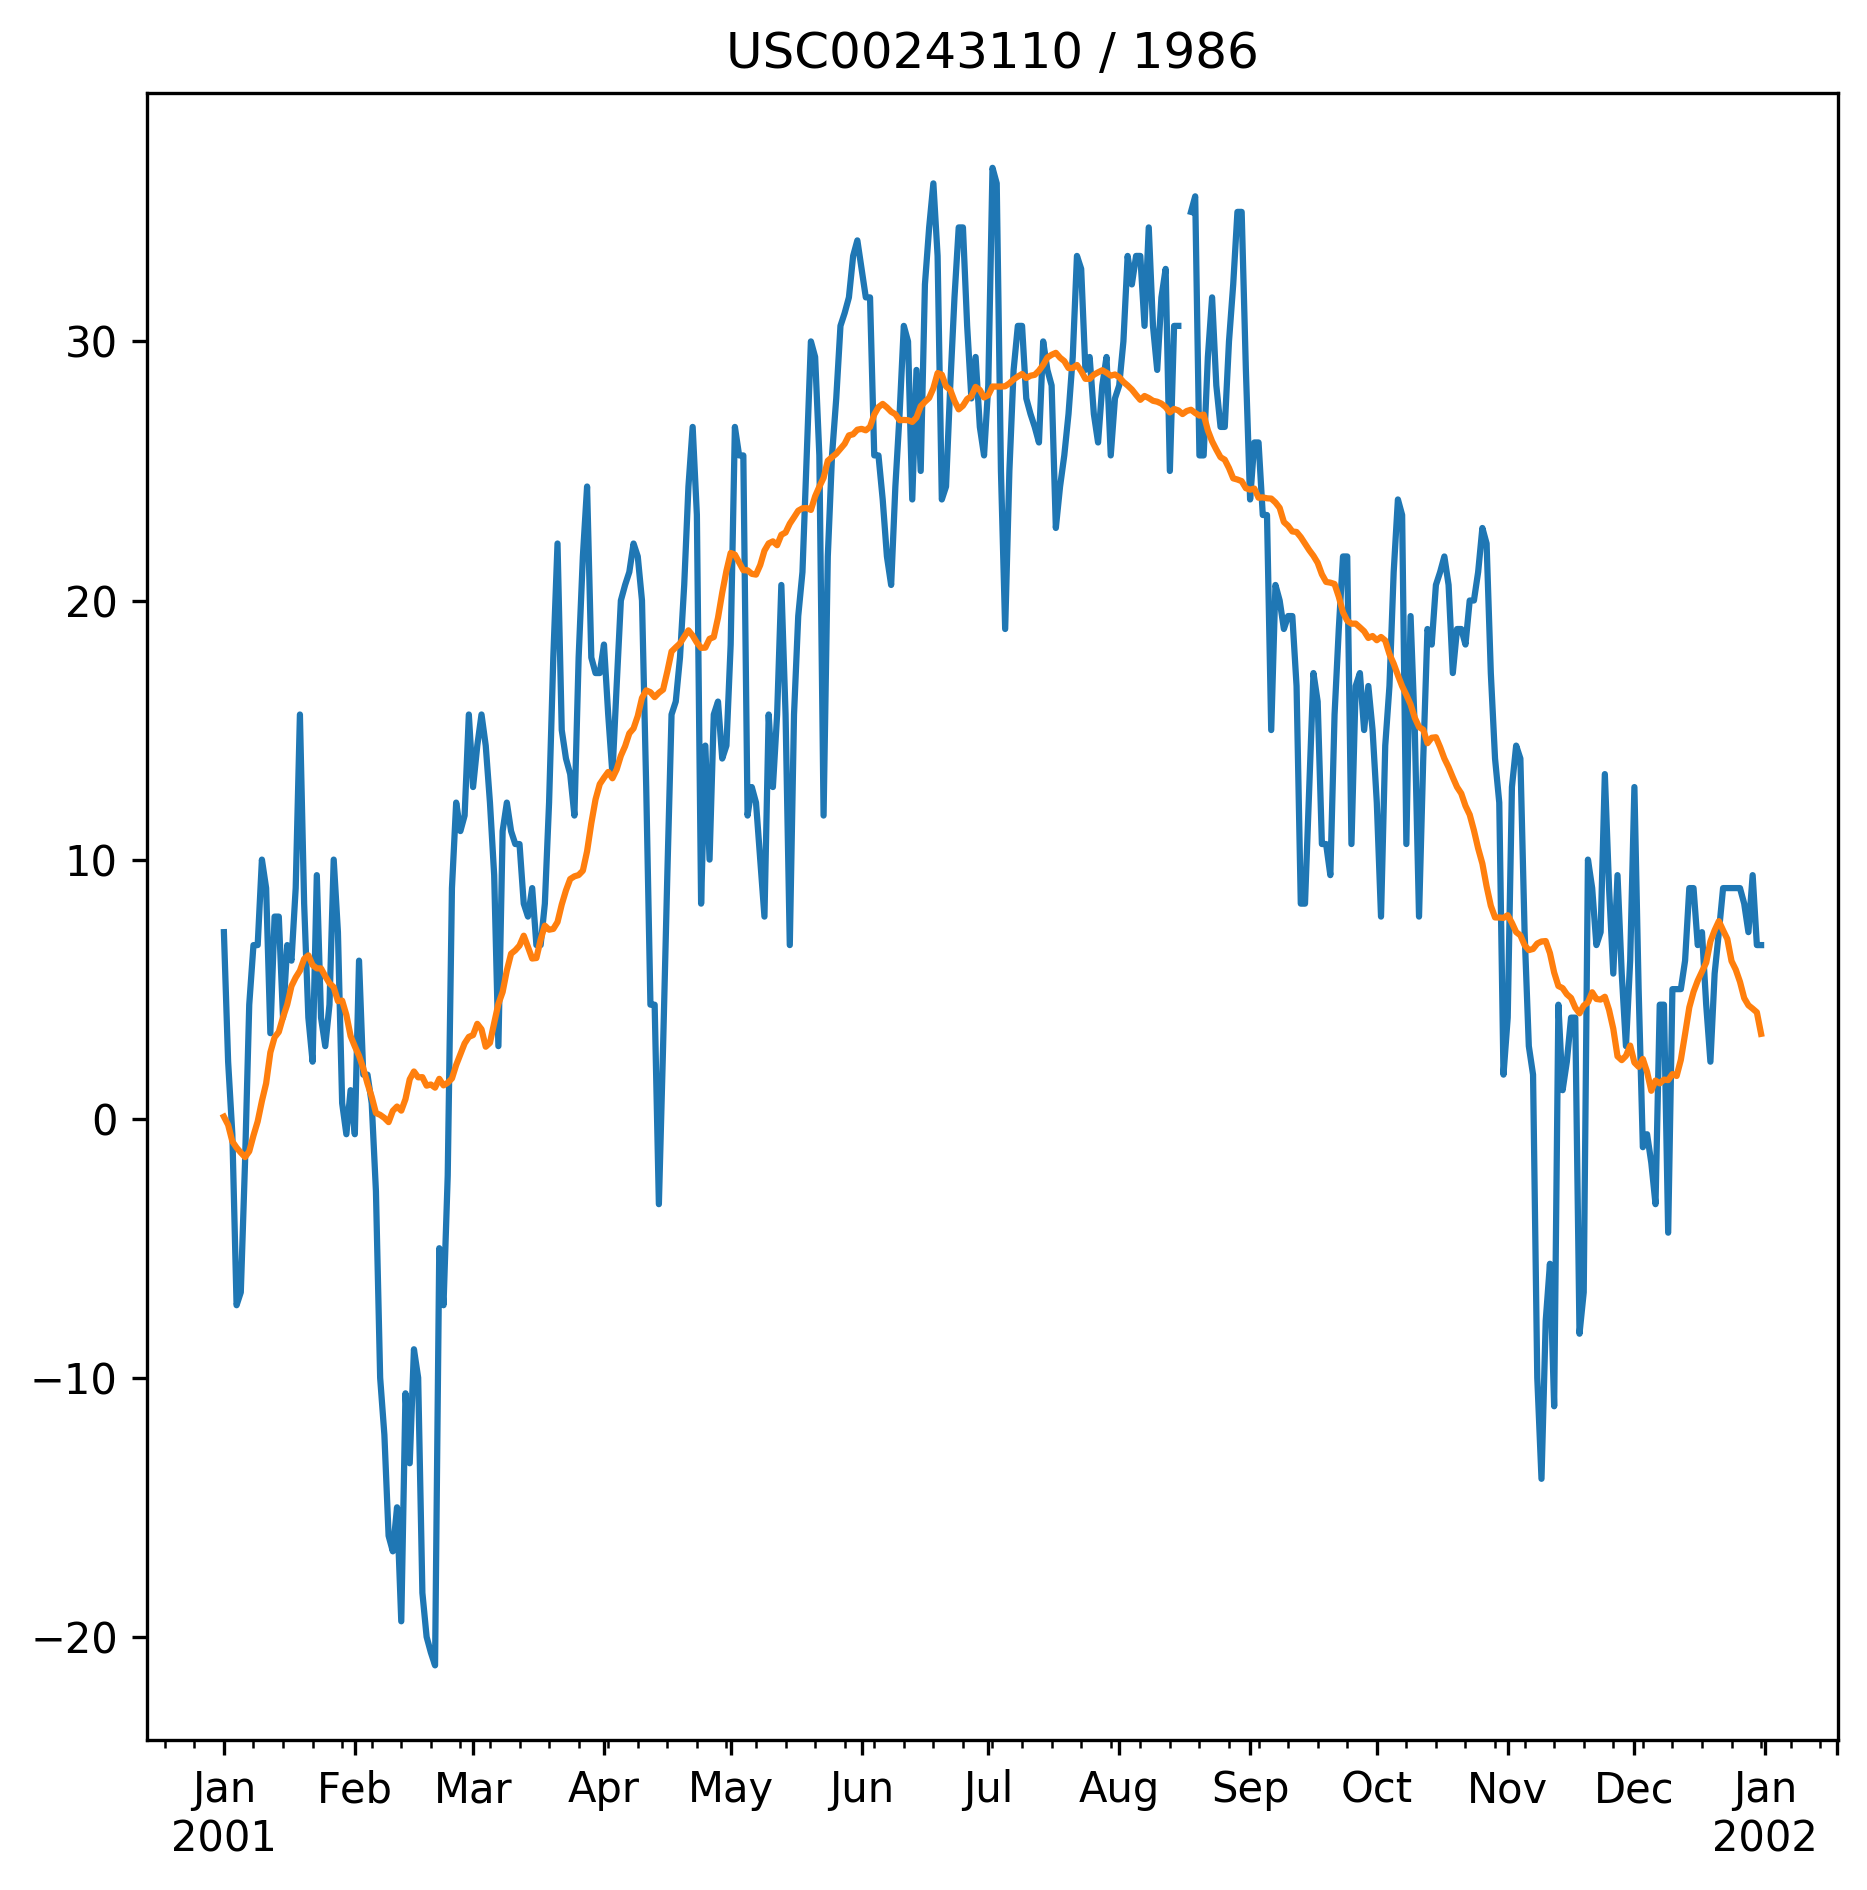

In [70]:
plot_reconstructions([2012],rows=2,columns=2,size=8)

<span style="color:red"> Check how the approximations change/improve as you increase the number of coefficients</span>

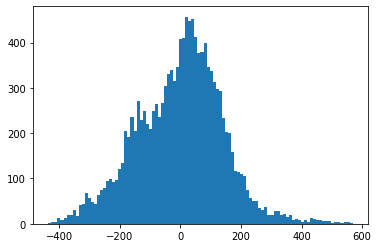

In [72]:
hist(Djoined.loc[:,'V0'],bins=100);

(654,)

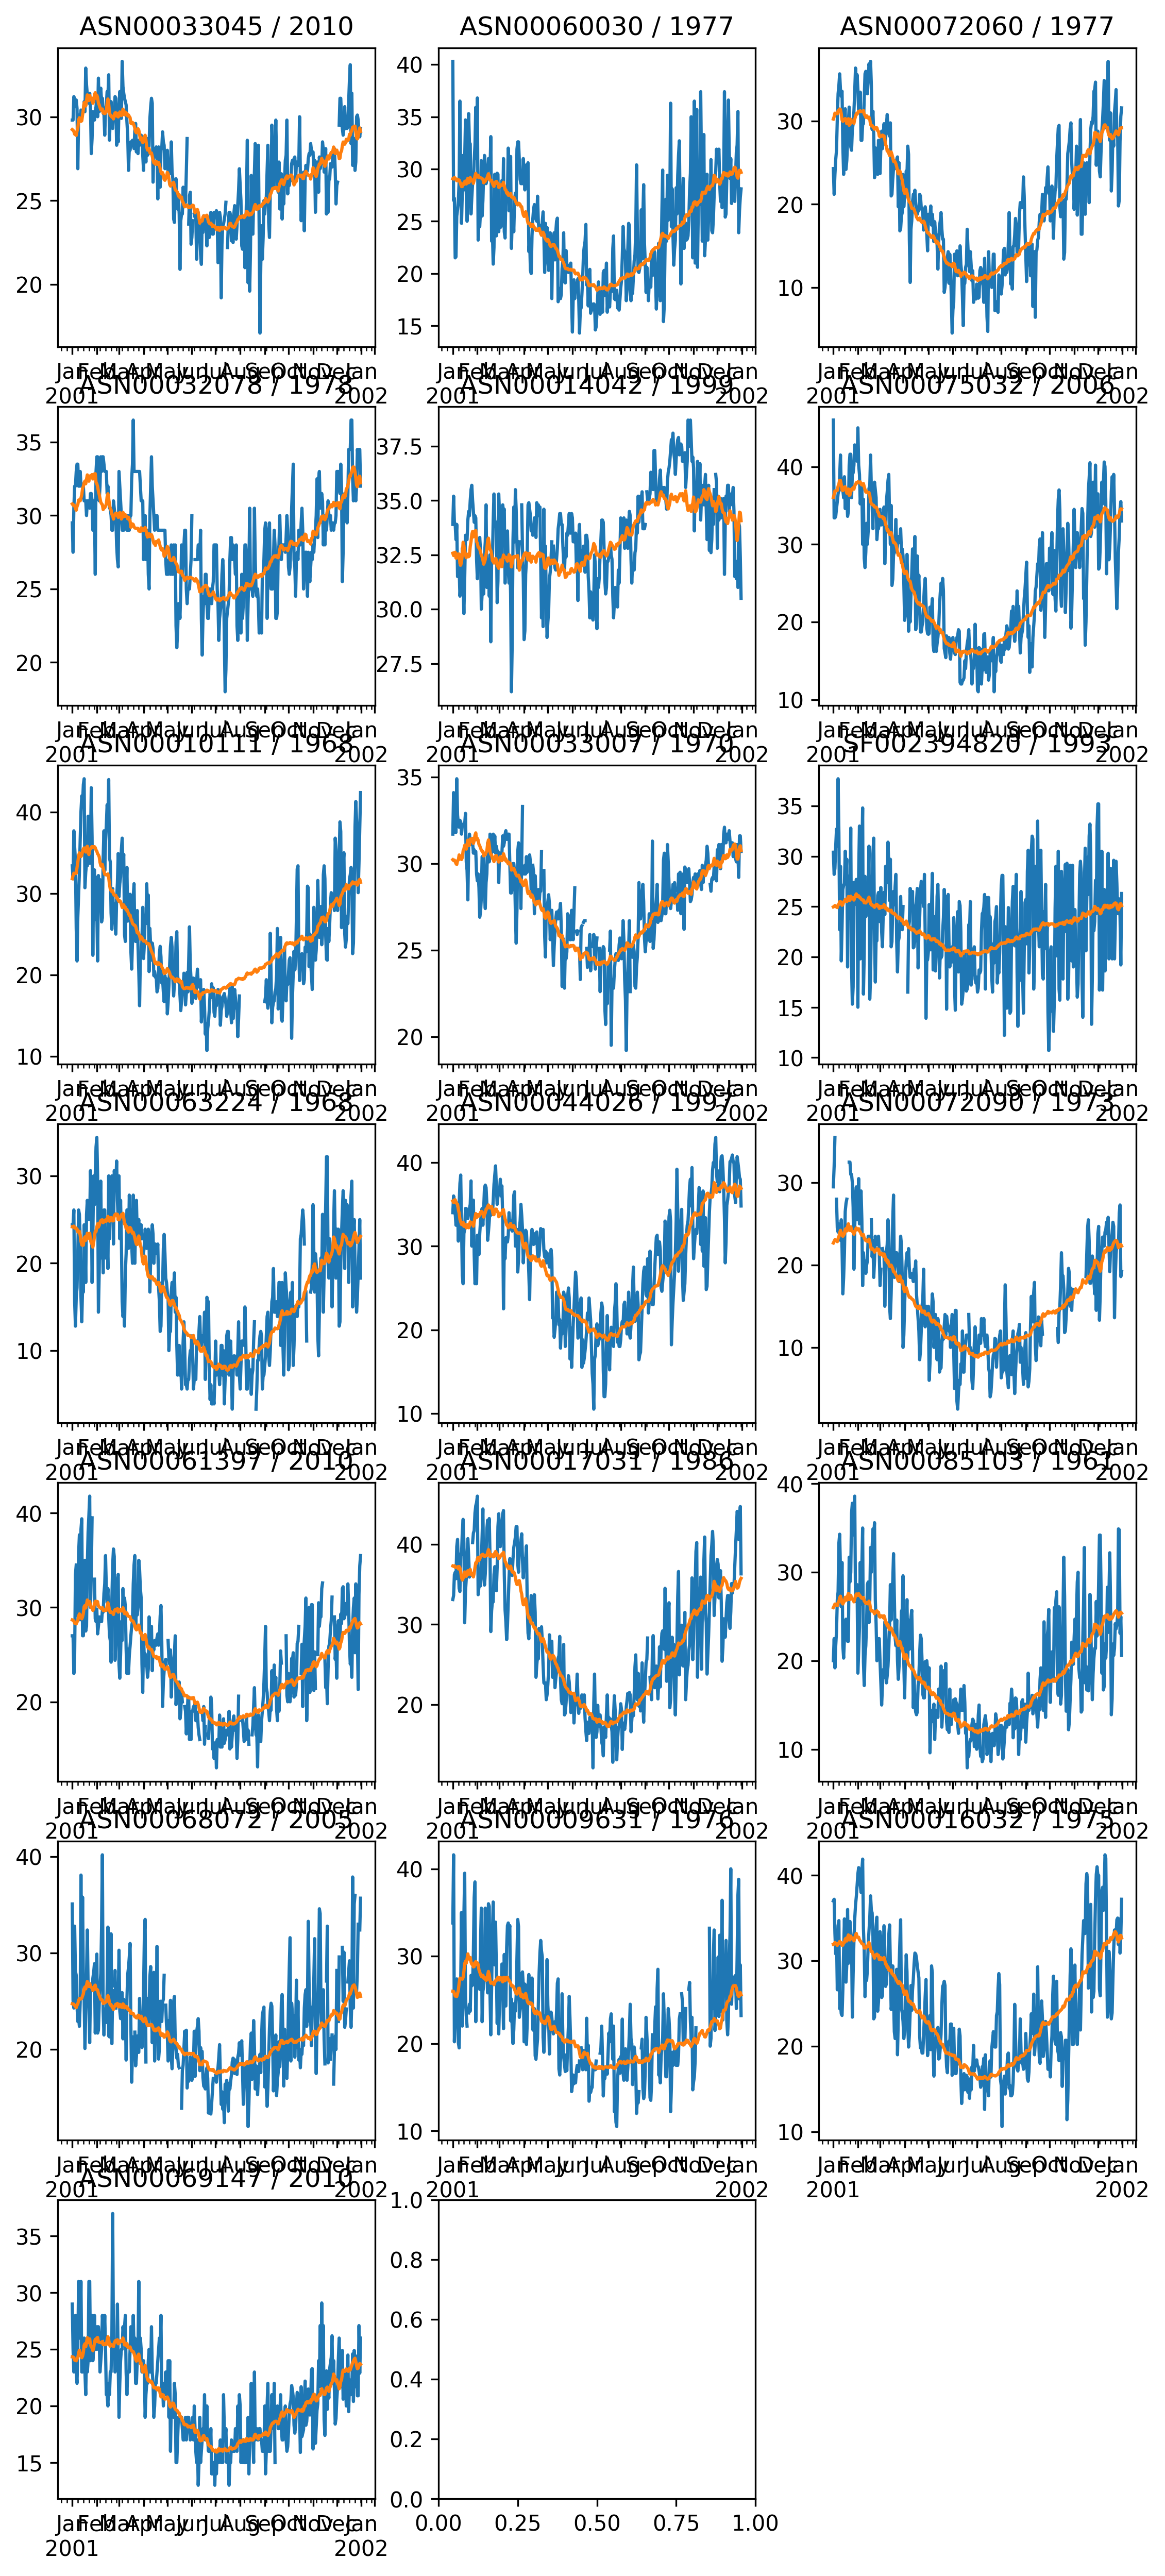

In [73]:
selection= [i for i in range(shape(Djoined)[0]) if Djoined.loc[i,'latitude']<-10]
plot_reconstructions(selection,rows=7,columns=3)
shape(selection)

<span style="color:red">Can you reduce the reconstruction error (using a fixed number of eigenvectors) by splitting the stations according to region (for example country, state, latitudal range). Note that having a regions with very few readings defeats the purpose.

In [ ]:
shape(np.array([Mean]).transpose())